# <center>RIP ibmq_armonk</center>

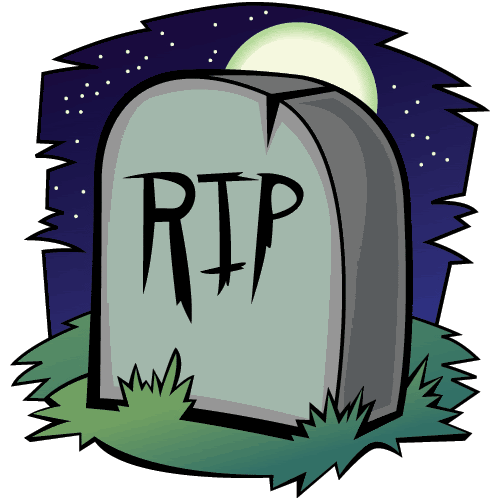

## <center>Long live Qiskit Pulse!</center>

In [1]:
from qiskit import IBMQ, pulse, assemble
from qiskit.pulse import DriveChannel, Play, Schedule
from qiskit.pulse.library import Gaussian

import numpy as np

In [2]:
# make the styles nice for dark background
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging
style = IQXDebugging()
style.update({"formatter.color.axis_label": "#ffffff",
              "formatter.color.fig_title": "#ffffff", 
              "formatter.general.fig_width": 20,
              "formatter.text_size.fig_title": 20,
              "formatter.control.show_acquire_channel": False})

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend_arm = provider.get_backend('ibmq_armonk')

In [4]:
backend_arm.configuration().open_pulse

True

In [5]:
qubit = 0 # it's the only one

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14
num_shots = 1024

In [6]:
center_frequency_Hz = backend_arm.defaults().qubit_freq_est[qubit] # qubit frequency given in Hz
                                                                    
print(f"Qubit {qubit} has an estimated frequency of %.3f GHz." % (center_frequency_Hz / GHz))

# sweep 100 MHz around the estimated frequency in steps of 2 MHz
frequency_span_Hz = 100 * MHz
frequency_step_Hz = 2 * MHz
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from %.3f GHz to %.3f GHz \
in steps of %.1f MHz." % ((frequency_min / GHz), (frequency_max / GHz), (frequency_step_Hz / MHz)))     

Qubit 0 has an estimated frequency of 4.972 GHz.
The sweep will go from 4.922 GHz to 5.022 GHz in steps of 2.0 MHz.


In [7]:
inst_sched_map_arm = backend_arm.defaults().instruction_schedule_map

x_arm = inst_sched_map_arm.get('x', qubits=[qubit])
meas_arm = inst_sched_map_arm.get('measure', qubits=[qubit])
x_arm.instructions

((0,
  Play(Drag(duration=320, amp=(0.8989824021594943+0j), sigma=80, beta=-0.9795992837348396, name='Xp_d0'), DriveChannel(0), name='Xp_d0')),)

## Ye Olde Pulse Syntax: Symbology

`+`: append an `Instruction` to the end of a `Schedule` <br>
  - used as `+=` to create and assign to a new `Schedule` the `Instruction` appended to the old `Schedule` <br>
  
`|`: merge two `Schedule`s <br>
  - used as `|=` to create and assign to a new `Schedule` merged with the `Instruction` <br>
  - Note that `Schedule`s contain timing information, whereas `Instruction`s do not <br>
  
`<<`: shift `Schedule` forward in time by a given amount <br>

In [8]:
# create the single base schedule
schedule = Schedule(name='Frequency sweep')
schedule |= x_arm
schedule |= meas_arm << schedule.duration

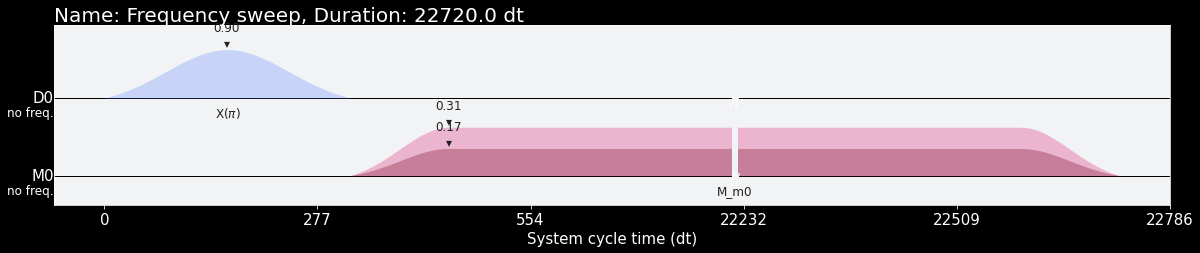

In [9]:
schedule.draw(style=style)

In [10]:
# define frequencies for the sweep
freqs = frequencies_GHz*GHz
schedule_freqs = [{DriveChannel(qubit): freq} for freq in freqs]

# assemble the program in to a QObj (deprecated)
# this constructs the same schedule, but with an array of LO frequencies for the sweep
freq_sweep_arm = assemble(schedule,
                             backend=backend_arm, 
                             meas_level=1,
                             meas_return='avg',
                             shots=num_shots,
                             schedule_los=schedule_freqs)

In [3]:

import qiskit.tools.jupyter
%qiskit_job_watcher

#job_arm = backend_arm.run(freq_sweep_arm)

In [13]:
job_results = job_arm.result() 
result_data = []
for idx in range(len(job_results.results)):
    result_data.append(job_results.get_memory(idx)[qubit]*scale_factor) 
    
sweep_data = np.real(result_data)

In [14]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [15]:
def lorentzian(x, A, q_freq, B, C): 
    return (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C

In [1]:
# do fit in Hz
(sweep_fit_params, sweep_y_fit) = fit_function(freqs,
                                   sweep_data, 
                                   lorentzian,
                                   [7, 4.975*GHz, 0.1*GHz, 3*GHz] # initial parameters for curve_fit
                                   )

In [2]:
plt.scatter(freqs/GHz, sweep_data, color='white')
plt.plot(freqs/GHz, sweep_y_fit, color='red')
plt.xlim([min(freqs/GHz), max(freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("Armonk: 0->1 Frequency Sweep", fontsize=15)
print("Measured qubit frequency is %.3f GHz" % (sweep_fit_params[1]/GHz))
plt.show()

## Modern Pulse Syntax on Armonk

Here we use the [Pulse Builder](https://qiskit.org/documentation/apidoc/pulse.html#pulse-builder) to write Pulse programs with an imperative syntax. After entering the Pulse Builder via
```
with pulse.build(name="my sched") as sched:
```
the user can enter contexts, i.e.
```
with pulse.align_sequential(): # align pulses sequentially
with pulse.frequency_offset(freq_off, DriveChannel(qubit)): # shift freq
with pulse.shift_phase(phase_off, DriveChannel(qubit)): # shift phase
```
where the contextual instructions only apply to the block of code within that context. These can also be nested to easily achieve complicated Pulse schedules!


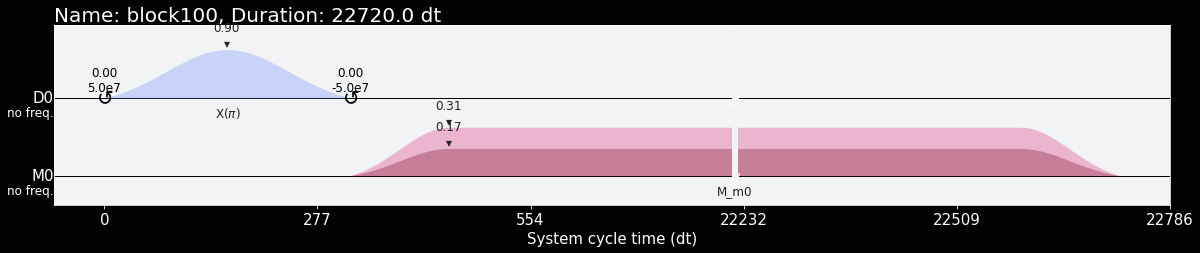

In [18]:
freq_offsets = np.linspace(-frequency_span_Hz/2, frequency_span_Hz/2, int(frequency_span_Hz/frequency_step_Hz)+1)
schedules = []
for freq_off in freq_offsets:
    with pulse.build() as sched:
        with pulse.align_sequential():
            with pulse.frequency_offset(freq_off, DriveChannel(qubit)):
                pulse.call(x_arm)
            pulse.call(meas_arm)
            
    schedules.append(sched)
    
schedules[-1].draw(style=style)

In [19]:
#job_arm2 = backend_arm.run(schedules, meas_level=1, meas_return='avg', shots=num_shots) 

In [ ]:
job_results = job_arm2.result() 
result_data = []
for idx in range(len(job_results.results)):
    result_data.append(job_results.get_memory(idx)[qubit]*scale_factor) 
    
sweep_data2 = np.real(result_data)

In [ ]:
# do fit in Hz
freqs2 = backend_arm.properties().frequency(qubit) - freq_offsets

(sweep_fit_params2, sweep_y_fit2) = fit_function(freqs2,
                                   sweep_data2, 
                                   lorentzian,
                                   [7, 4.975*GHz, 0.1*GHz, 3*GHz] # initial parameters for curve_fit
                                   )

In [ ]:
plt.scatter(freqs2/GHz, sweep_data2, color='white')
plt.plot(freqs2/GHz, sweep_y_fit2, color='red')
plt.xlim([min(freqs/GHz), max(freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("Armonk: 0->1 Frequency Sweep", fontsize=15)
print("Measured qubit frequency is %.3f GHz" % (sweep_fit_params2[1]/GHz))
plt.show()

## Pulse Gates on Belem

In [20]:
backend_bel = provider.get_backend('ibmq_belem')

In [21]:
# newer backends support Pulse Gates, maybe not Open Pulse
inst_sched_map_bel = backend_bel.defaults().instruction_schedule_map
backend_bel.configuration().open_pulse

False

In [22]:
x_bel = inst_sched_map_bel.get('x', qubits=[qubit])
x_bel.instructions

((0,
  Play(Drag(duration=160, amp=(0.2368545123054496+0j), sigma=40, beta=-2.4528182342618456, name='Xp_d0'), DriveChannel(0), name='Xp_d0')),)

## Compare $X_\pi$ Pulses on Armonk & Belem

Let's create a schedule and plot the $X_\pi$-pulses for Armonk & Belem sequentially. We can already see from the `.instructions` that

Pulse | Armonk     | Belem |
-------- | ----------- | ----------- |
Amplitude | 0.9      | 0.2      |
Duration | 320  | 160        |

showing the the Armonk pulse has a much higher amplitude and twice the duration of an equivalent $X_\pi$ pulse for Belem.

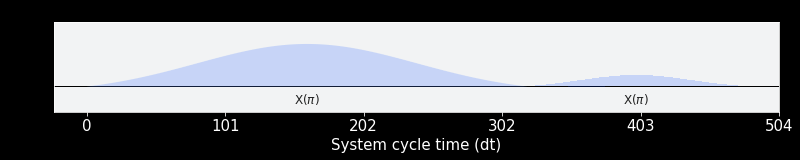

In [23]:
with pulse.build() as comp_sched:
    with pulse.align_sequential():
        pulse.call(x_arm)
        pulse.call(x_bel)
        
comp_sched.draw()

## Create the Circuit for Spectroscopy

Here we use the Circuit language instead of the Pulse language. Our spectroscopy experiment consists of a single $X\pi$ pulse (or `XGate()`) schedule (circuit), and then we construct an array of those but changing the `DriveChannel` frequency for each one. This can be done in the Circuit language by using Pulse Gates.

In [24]:
from qiskit.circuit import Gate, QuantumCircuit

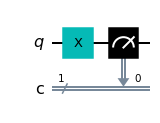

In [25]:
spec_circ = QuantumCircuit(1, 1)
spec_circ.x(0)
spec_circ.measure(0, 0)
spec_circ.draw(output='mpl')

In [26]:
from copy import deepcopy

spec_circs = []
for freq_off in freq_offsets:
    spec_circ_off = deepcopy(spec_circ)
    with pulse.build() as sched:
        with pulse.frequency_offset(freq_off, DriveChannel(qubit)):
            pulse.call(x_bel)
        
        spec_circ_off.add_calibration('x', [qubit], sched)
            
    spec_circs.append(spec_circ_off)

In [ ]:
#spec_circs[-1].calibrations
job_bel = backend_bel.retrieve_job('621950a1c799dbb50aefbfeb') 

In [27]:
job_bel = backend_bel.run(spec_circs, meas_level=1, meas_return='avg', shots=num_shots)

In [ ]:
job_results = job_bel.result() 
result_data = []
for idx in range(len(job_results.results)):
    result_data.append(job_results.get_memory(idx)[qubit]*scale_factor) 
    
sweep_data3 = np.real(result_data)

In [ ]:
# do fit in Hz
freqs3 = backend_bel.properties().frequency(qubit) - freq_offsets

(sweep_fit_params3, sweep_y_fit3) = fit_function(freqs3,
                                   sweep_data3, 
                                   lorentzian,
                                   [7, 5.1*GHz, 0.1*GHz, 3*GHz] # initial parameters for curve_fit
                                   )

In [ ]:
plt.scatter(freqs3/GHz, sweep_data3, color='white')
plt.plot(freqs3/GHz, sweep_y_fit3, color='red')
plt.xlim([min(freqs3/GHz), max(freqs3/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("Belem: 0->1 Frequency Sweep", fontsize=15)
print("Measured qubit frequency is %.3f GHz" % (sweep_fit_params3[1]/GHz))
plt.show()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table